# Extreme Gradient Boosting (XGBoost) Training and Analysis

In [2]:
import sqlite3
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np

# Import Data from Database

In [7]:
# connect to the database
conn = sqlite3.connect('../features.db')
c = conn.cursor()
# get training, validation and test data
train = pd.read_sql_query("SELECT * FROM train", conn)
valid = pd.read_sql_query("SELECT * FROM validation", conn)
test = pd.read_sql_query("SELECT * FROM test", conn)
# close the connection
conn.close()

## Format Data for Machine Learning

In [8]:
# get the target and features
train_y = train['y']
train_y = train_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
train_x = train.drop(columns=['y'])

valid_y = valid['y']
valid_y = valid_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
valid_x = valid.drop(columns=['y'])

test_y = test['y']
test_y = test_y.map({'GSVT': 0, 'AFIB': 1, 'SR': 2, 'SB': 3})
test_x = test.drop(columns=['y'])

# drop id column
train_x = train_x.drop(columns=['id'])
valid_x = valid_x.drop(columns=['id'])
test_x = test_x.drop(columns=['id'])

print('train_x shape:', train_x.shape)
print('test_x shape:', test_x.shape)
print('valid_x shape:', valid_x.shape)

# print column names
print('features:', train_x.columns.to_list())

# use xgboost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)
dtest = xgb.DMatrix(test_x, label=test_y)

num_classes= len(set(valid_y.to_list()))
print('number of classes:', num_classes)

train_x shape: (3502, 10)
test_x shape: (438, 10)
valid_x shape: (438, 10)
features: ['age', 'gender', 'artial_rate', 'ventricular_rate', 'qrs_duration', 'qt_length', 'qrs_count', 'q_peak', 'r_axis', 't_axis']
number of classes: 4


# Test Grid for Hyperparameter Analysis

In [47]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'eta': [0.1, 0.2, 0.3],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300]
}

In [39]:
# Create a XGBClassifier object
model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='merror')

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')


## Training

In [40]:
%%time
# Fit the grid search object to the data
grid_search.fit(train_x, train_y)

CPU times: total: 2h 15min 58s
Wall time: 10min


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='merror', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     ma...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=4,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.1, 0.2, 0.3],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

# Results

In [41]:
# Print the best parameters and the best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
#{'eta': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}

Best parameters: {'eta': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}
Best score: 0.8012537024646579


## Save Model

In [44]:
# Save the best model
best_model = grid_search.best_estimator_
# timestamp
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
best_model.save_model(f'../ml_models/best_xgb_model_{timestamp}.json')

# Example Training of best Model

load the best model to get the best hyperparameters from it

In [3]:
# list directory
models = os.listdir('../ml_models')
model_path = [model for model in models if 'json' in model and 'best' in model and 'xgb' in model][0]
model_path = f'../ml_models/{model_path}'
# load the best model
best_model = xgb.Booster()
best_model.load_model(model_path)
best_params = best_model.attributes()
print('best model:', best_params)

best model: {'best_iteration': '99', 'best_ntree_limit': '100', 'scikit_learn': '{"use_label_encoder": false, "n_estimators": 100, "objective": "multi:softmax", "max_depth": 5, "max_leaves": null, "max_bin": null, "grow_policy": null, "learning_rate": 0.1, "verbosity": null, "booster": null, "tree_method": null, "gamma": null, "min_child_weight": 3, "max_delta_step": null, "subsample": null, "sampling_method": null, "colsample_bytree": null, "colsample_bylevel": null, "colsample_bynode": null, "reg_alpha": null, "reg_lambda": null, "scale_pos_weight": null, "base_score": null, "missing": NaN, "num_parallel_tree": null, "random_state": null, "n_jobs": null, "monotone_constraints": null, "interaction_constraints": null, "importance_type": null, "gpu_id": null, "validate_parameters": null, "predictor": null, "enable_categorical": false, "max_cat_to_onehot": null, "eval_metric": "merror", "early_stopping_rounds": null, "callbacks": null, "kwargs": {"num_class": 4, "eta": 0.1}, "classes_": 

In [9]:
%%time
# train the models
# add the best parameters to the model
#best_params = grid_search.best_params_.copy()
best_params['objective'] = 'multi:softmax'
best_params['eval_metric'] = 'merror'
best_params['num_class'] = num_classes

num_round = 100

# Train the model and get the training history
evals_result = {}
model = xgb.train(best_params, dtrain, num_round, evals=[(dtrain, 'train'), (dvalid, 'eval')], evals_result=evals_result)

[16:58:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "best_iteration", "best_ntree_limit", "scikit_learn" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-merror:0.16762	eval-merror:0.22603
[1]	train-merror:0.15220	eval-merror:0.22374
[2]	train-merror:0.13849	eval-merror:0.21461
[3]	train-merror:0.13535	eval-merror:0.20776
[4]	train-merror:0.13278	eval-merror:0.20091
[5]	train-merror:0.12907	eval-merror:0.20548
[6]	train-merror:0.12307	eval-merror:0.20320
[7]	train-merror:0.11850	eval-merror:0.20320
[8]	train-merror:0.11422	eval-merror:0.19406
[9]	train-merror:0.10965	eval-merror:0.20091
[10]	train-merror:0.10280	eval-merror:0.20320
[11]	train-merror:0.09880	eval-merror:0.19406

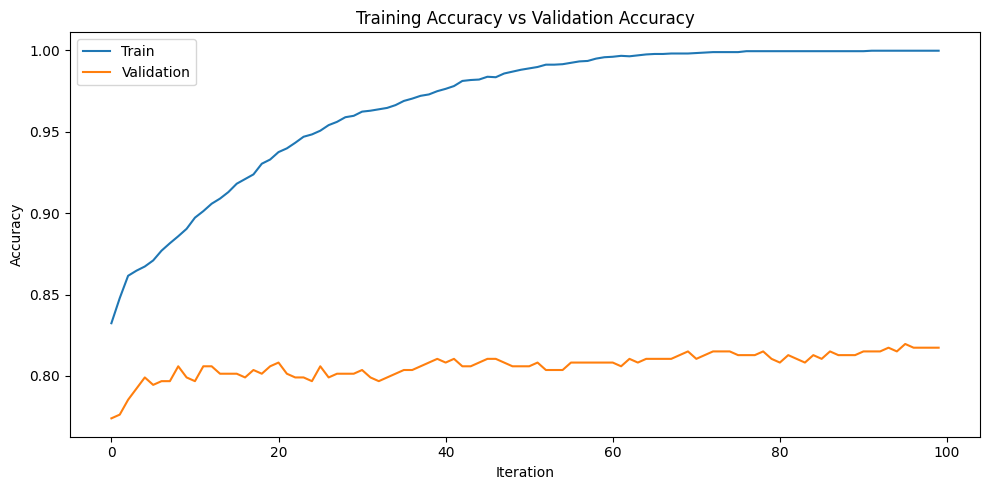

In [10]:
# Get the training loss and validation loss
train_loss = evals_result['train']['merror']
valid_loss = evals_result['eval']['merror']

# Calculate the training accuracy and validation accuracy
train_accuracy = [1 - x for x in train_loss]
valid_accuracy = [1 - x for x in valid_loss]

# Create a new figure
fig = plt.figure(figsize=(10, 5))

# Plot the training accuracy and validation accuracy
plt.plot(train_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Get the accuracy of the model
preds = model.predict(dtest)
correct = 0
for i in range(len(test_y)):
    if preds[i] == test_y[i]:
        correct += 1
accuracy = correct / len(test_y)
print('Accuracy:', accuracy)

Accuracy: 0.8310502283105022


# Evaluate Model Performance

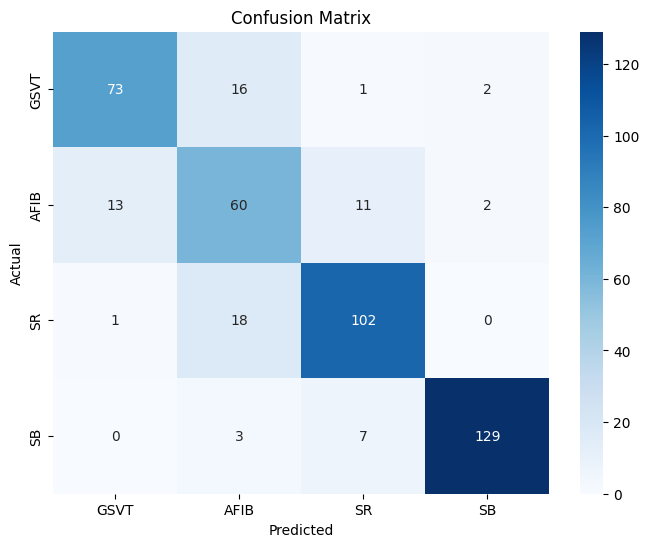

In [12]:
# Get the confusion matrix
cm = confusion_matrix(test_y, preds)

# Create a new figure
plt.figure(figsize=(8, 6))

labels = ['GSVT', 'AFIB', 'SR', 'SB']
# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

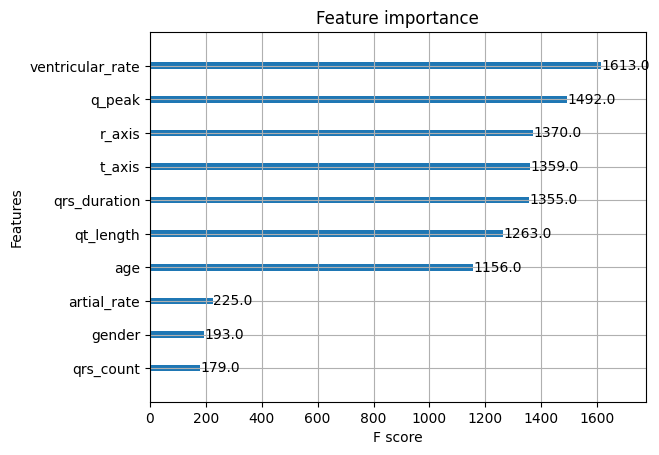

In [13]:
# plot the feature importance
xgb.plot_importance(model)

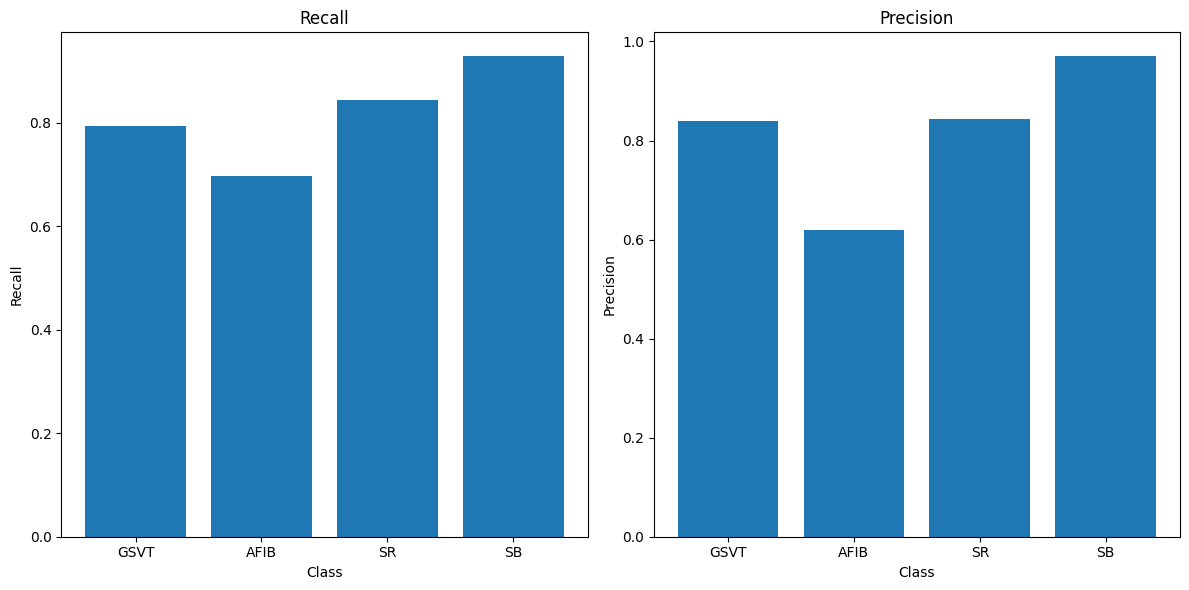

In [14]:
# plot recall and precision
# Calculate the recall and precision
recall = cm.diagonal() / cm.sum(axis=1)
precision = cm.diagonal() / cm.sum(axis=0)

# plot in a bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(num_classes), recall)
ax[0].set_xticks(range(num_classes))
ax[0].set_xticklabels(['GSVT', 'AFIB', 'SR', 'SB'])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Recall')
ax[0].set_title('Recall')

ax[1].bar(range(num_classes), precision)
ax[1].set_xticks(range(num_classes))
ax[1].set_xticklabels(['GSVT', 'AFIB', 'SR', 'SB'])
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision')

plt.tight_layout()
plt.show()

In [29]:
# Calculate F1 Score for multiclass classification
f1 = f1_score(test_y, preds, average='macro')

print('F1 Score:', f1)

F1 Score: 0.8157211953487169
